In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
import math
from scipy.stats import pearsonr, spearmanr


from env import get_connection
import wrangle_zillow
import prepare


# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")


## 1. Load your zillow dataset.

In [4]:
df = wrangle_zillow.wrangle_zillow()
df.head()

,bath,bed,sqft,fin_sqft,fips,full_bath,lotsize,zipcode,rooms,yearbuilt,taxvaluedollarcnt
0,3,4,3100.0,3100.0,6059,3.0,4506.0,96978.0,0.0,1998,1023282
1,1,2,1465.0,1465.0,6111,1.0,12647.0,97099.0,5.0,1967,464000
2,2,3,1243.0,1243.0,6059,2.0,8432.0,97078.0,6.0,1962,564778
3,3,4,2376.0,2376.0,6037,3.0,13038.0,96330.0,0.0,1970,145143
4,3,4,2962.0,2962.0,6037,3.0,63000.0,96293.0,0.0,1950,773303


In [5]:
train, val, test = prepare.train_val_test(df)
train.shape, val.shape, test.shape

((36187, 11), (9305, 11), (6204, 11))

In [6]:
train.head()

,bath,bed,sqft,fin_sqft,fips,full_bath,lotsize,zipcode,rooms,yearbuilt,taxvaluedollarcnt
30731,3,4,2667.0,2667.0,6059,3.0,6957.0,96958.0,8.0,1967,878133
24450,1,2,1438.0,1438.0,6059,1.0,1763.0,96186.0,6.0,1977,352000
35967,2,3,1203.0,1203.0,6059,2.0,8250.0,96965.0,7.0,1963,373126
36633,2,3,1981.0,1981.0,6059,2.0,4500.0,96948.0,9.0,1987,572796
50019,3,3,2562.0,2562.0,6037,3.0,2992.0,96128.0,0.0,1997,862713


## 2. Fit a linear regression model (ordinary least squares) and compute that, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [9]:
train = train.drop(columns=['bed', 'bath', 'fin_sqft', 'full_bath', 'lotsize', 'zipcode',
                    'yearbuilt', 'rooms', 'fips'])

In [10]:
train.head()

,sqft,taxvaluedollarcnt
30731,2667.0,878133
24450,1438.0,352000
35967,1203.0,373126
36633,1981.0,572796
50019,2562.0,862713


In [11]:
MinMax = MinMaxScaler()

train['sqft'] = MinMax.fit_transform(train[['sqft']])

In [13]:
train.head()

,sqft,taxvaluedollarcnt
30731,0.250775,878133
24450,0.123786,352000
35967,0.099504,373126
36633,0.179893,572796
50019,0.239926,862713


In [14]:
train.describe().loc[['count','min','max']]

,sqft,taxvaluedollarcnt
count,36187.0,36187.0
min,0.0,1000.0
max,1.0,11020600.0


In [17]:
X_train = train[['sqft']]
y_train = train[['taxvaluedollarcnt']]

X_val = val[['sqft']]
y_val = val[['taxvaluedollarcnt']]

X_test = test[['sqft']]
y_test = test[['taxvaluedollarcnt']]

In [19]:
X_train.head()

,sqft
30731,0.250775
24450,0.123786
35967,0.099504
36633,0.179893
50019,0.239926


In [20]:
model = LinearRegression().fit(X_train, y_train)


model

LinearRegression()

In [21]:
predictions = model.predict(X_train)

predictions

array([[ 807836.96459684],
       [ 328567.71841108],
       [ 236925.51104439],
       ...,
       [1047276.6042698 ],
       [ 333247.32048938],
       [ 125394.99484494]])

In [22]:
train['yhat'] = predictions

In [24]:
train.head()

,sqft,taxvaluedollarcnt,yhat
30731,0.250775,878133,807836.964597
24450,0.123786,352000,328567.718411
35967,0.099504,373126,236925.511044
36633,0.179893,572796,540319.712454
50019,0.239926,862713,766890.446412


## 3. Plot the residuals for the linear regression model that you made.

In [26]:
train['residuals'] =  train.yhat - train.taxvaluedollarcnt

In [27]:
train.head()

,sqft,taxvaluedollarcnt,yhat,residuals
30731,0.250775,878133,807836.964597,-70296.035403
24450,0.123786,352000,328567.718411,-23432.281589
35967,0.099504,373126,236925.511044,-136200.488956
36633,0.179893,572796,540319.712454,-32476.287546
50019,0.239926,862713,766890.446412,-95822.553588


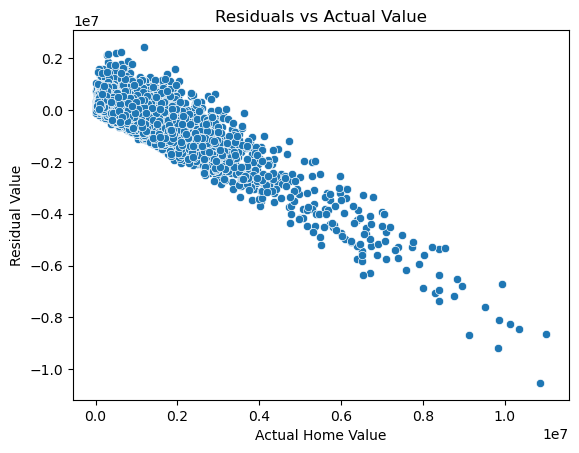

In [28]:
sns.scatterplot(data=train, x='taxvaluedollarcnt', y='residuals')

plt.xlabel('Actual Home Value')
plt.ylabel('Residual Value')
plt.title('Residuals vs Actual Value')
plt.show()

## 4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

In [29]:
SSE = (train.residuals **2).sum()
SSE

8520243013163563.0

In [31]:
ESS = ((train.yhat - train.taxvaluedollarcnt.mean())**2).sum()
ESS

5050554072923080.0

In [32]:
TSS = ESS + SSE
TSS

1.3570797086086644e+16

In [33]:
SSE/len(train.yhat)

235450383097.89603

In [35]:
MSE = mean_squared_error(train.taxvaluedollarcnt, train.yhat)
MSE

235450383097.89603

In [36]:
RMSE = MSE**.5
RMSE

485232.2980778341

In [39]:
math.sqrt(MSE)

485232.2980778341

## 5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount)

In [40]:
train['baseline'] = train.taxvaluedollarcnt.mean()

In [42]:
MSE_baseline = mean_squared_error(train.taxvaluedollarcnt, train.baseline)
MSE_baseline

375018572583.70795

In [43]:
train['MSE_baseline'] = MSE_baseline

In [44]:
SSE_baseline = MSE_baseline * len(train)
SSE_baseline

1.357079708608664e+16

In [45]:
train['SSE_baseline'] = SSE_baseline

In [46]:
RMSE_baseline = MSE_baseline**.5
RMSE_baseline

612387.5999591337

In [47]:
train['RMSE_baseline'] = RMSE_baseline

In [48]:
train.head()

,sqft,taxvaluedollarcnt,yhat,residuals,baseline,MSE_baseline,SSE_baseline,RMSE_baseline
30731,0.250775,878133,807836.964597,-70296.035403,512675.668279,3.750186e+11,1.357080e+16,612387.599959
24450,0.123786,352000,328567.718411,-23432.281589,512675.668279,3.750186e+11,1.357080e+16,612387.599959
35967,0.099504,373126,236925.511044,-136200.488956,512675.668279,3.750186e+11,1.357080e+16,612387.599959
36633,0.179893,572796,540319.712454,-32476.287546,512675.668279,3.750186e+11,1.357080e+16,612387.599959
50019,0.239926,862713,766890.446412,-95822.553588,512675.668279,3.750186e+11,1.357080e+16,612387.599959


## 6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [49]:
if SSE < SSE_baseline:
    print('My OSL model performs better than baseline')
else:
    print('My OSL model performs worse than baseline. :( )')

My OSL model performs better than baseline


## 7. What is the amount of variance explained in your model?

In [50]:
R2 = ESS / TSS
R2

0.3721634065327763

In [51]:
print('R-squared = ',round(R2,3))
print("Percent of variance = ", round(R2*100,1), "%")

R-squared =  0.372
Percent of variance =  37.2 %


In [55]:
r2_score(train.taxvaluedollarcnt, train.yhat)

0.37216340653277624

In [57]:
evs = explained_variance_score(train.taxvaluedollarcnt, train.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.372


## 8. Is your model better than the baseline model?

In [58]:
RMSE_baseline - RMSE

127155.30188129959

In [59]:
if RMSE < RMSE_baseline:
    print(f'The model rmse performs better the rmse_baseline')
else:
    print(f'The model rmse performs worse than the rmse_baseline')

The model rmse performs better the rmse_baseline


## 9. Create a file named evaluate.py that contains the following functions.

* plot_residuals(y, yhat): creates a residual plot
* regression_errors(y, yhat): returns the following values:
* sum of squared errors (SSE)
* explained sum of squares (ESS)
* total sum of squares (TSS)
* mean squared error (MSE)
* root mean squared error (RMSE)
* baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
* better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false

In [61]:
def plot_residuals(y, yhat):
    '''
    This function takes in actual value and predicted value 
    then creates a scatter plot of those values
    '''
    residuals = y - yhat
    
    plt.scatter(x=y, y=residuals)
    plt.xlabel('Home Value')
    plt.ylabel('Residuals')
    plt.title('Residual vs Home Value Plot')
    plt.show()

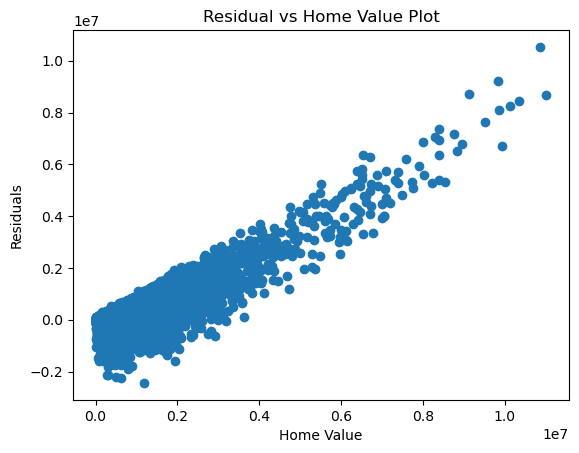

In [62]:
plot_residuals(train.taxvaluedollarcnt, train.yhat)

In [63]:
def regression_errors(y, yhat):
    '''
    This function takes in actual value and predicted value 
    then outputs: the sse, ess, tss, mse, and rmse
    '''
    MSE = mean_squared_error(y, yhat)
    SSE = MSE * len(y)
    RMSE = math.sqrt(MSE)
    ESS = ((yhat - y.mean())**2).sum()
    TSS = ESS + SSE
           
    print(f'SSE: {SSE: .4f}')
    print(f'ESS: {ESS: .4f}')
    print(f'TSS: {TSS: .4f}')
    print(f'MSE: {MSE: .4f}')
    print(f'RMSE: {RMSE: .4f}')

    return MSE, SSE, RMSE, ESS, TSS

In [64]:
regression_errors(train.taxvaluedollarcnt, train.yhat)

SSE:  8520243013163564.0000
ESS:  5050554072923080.0000
TSS:  13570797086086644.0000
MSE:  235450383097.8960
RMSE:  485232.2981


(235450383097.89603,
 8520243013163564.0,
 485232.2980778341,
 5050554072923080.0,
 1.3570797086086644e+16)

In [65]:
def baseline_mean_errors(y):
    baseline = np.repeat(y.mean(), len(y))
    
    MSE = mean_squared_error(y, baseline)
    SSE = MSE * len(y)
    RMSE = MSE**.5
    
    print(f'sse_baseline: {SSE: .4f}')
    print(f'mse_baseline: {MSE: .4f}')
    print(f'rmse_baseline: {RMSE: .4f}')
    
    return MSE, SSE, RMSE

In [67]:
baseline_mean_errors(train.taxvaluedollarcnt)

sse_baseline:  13570797086086640.0000
mse_baseline:  375018572583.7079
rmse_baseline:  612387.6000


(375018572583.70795, 1.357079708608664e+16, 612387.5999591337)

In [68]:
def better_than_baseline(y, yhat):
    '''
    This function takes in the target and the prediction
    then returns a print statement 
    to inform us if the model outperforms the baseline
    '''
    SSE, ESS, TSS, MSE, RMSE = regression_errors(y, yhat)
    
    SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(y)
    
    if SSE < SSE_baseline:
        print('My OSL model performs better than baseline')
    else:
        print('My OSL model performs worse than baseline. :( )')

In [69]:
better_than_baseline(train.taxvaluedollarcnt, train.yhat)


SSE:  8520243013163564.0000
ESS:  5050554072923080.0000
TSS:  13570797086086644.0000
MSE:  235450383097.8960
RMSE:  485232.2981
sse_baseline:  13570797086086640.0000
mse_baseline:  375018572583.7079
rmse_baseline:  612387.6000
My OSL model performs better than baseline
